In [ ]:
import os
import sys

from google.colab import drive
drive.mount('/content/drive')
troncho_base = '/content/drive/MyDrive/Your_Folder'
os.chdir(troncho_base)
sys.path.append(troncho_base)

WORKING_FOLDER = '/content/drive/MyDrive/ai-sex-class-paper-main'
DATASETS = './datasets'

Mounted at /content/drive


In [ ]:
!pip install munch
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_

In [ ]:
import torch
# Import Local
from src.utils import config
from src.buildmodel import build_model
from src.utils.modelfile import load_model

from pytorch_grad_cam import LayerCAM, GradCAM, HiResCAM, GradCAMPlusPlus, ScoreCAM, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

import cv2
import numpy as np
import matplotlib.pyplot as plt

def build_and_load_model(parameters, model_file ):
    model, device = build_model(parameters)
    load_model(parameters=parameters, model=model, model_file=model_file+'.pth')
    model.eval()
    return model, device


In [ ]:
#Loading the data sets
kbest_f_mhe_idxs = [134, 98, 137, 110, 148, 187, 128, 114, 122, 152]
kbest_m_mhe_idxs = [ 91, 16, 53, 63, 86, 78,  82, 31,  6, 15]
kbest_f_org_idxs = [117, 141, 137, 143, 132, 174, 170,  183,  185,  113]
kbest_m_org_idxs = [ 64, 15, 60, 75, 79, 83, 23, 65, 16, 90]
kbest_f_omask_idxs = [ 98, 134, 148,  173,  187,  138, 142, 195, 162, 170]
kbest_m_omask_idxs = [86, 16, 53, 6, 31, 9, 59, 69, 29, 43]

tst_file = DATASETS + '/xray_masked_he/tst_masked_he_400x300.npz'
data = np.load(tst_file)
images = data['data']/255
print('masked-he', images.shape)
best_female_mhe = images[kbest_f_mhe_idxs]
best_male_mhe = images[kbest_m_mhe_idxs]

tst_file = DATASETS + '/xray_original/tst_original_400x300.npz'
data = np.load(tst_file)
images = data['data']/255
print('original', images.shape)
best_female_org = images[kbest_f_org_idxs]
best_male_org   = images[kbest_m_org_idxs]

tst_file = DATASETS + '/only_masks/tst_masks_400x300.npz'
data = np.load(tst_file)
images = data['data']/255
print('only-masks', images.shape)
best_female_omask = images[kbest_f_omask_idxs]
best_male_omask   = images[kbest_m_omask_idxs]

data_shape      = [best_male_mhe.shape, best_male_org.shape, best_male_omask.shape]
print(data_shape)
data_sets       = [[best_female_mhe, best_male_mhe],
                   [best_female_org, best_male_org],
                   [best_female_omask, best_male_omask]]

data_sets_names = [['best_female_mhe', 'best_male_mhe'],
                   ['best_female_org', 'best_male_org'],
                   ['best_female_omask', 'best_male_omask']]

data_sets_idxs  = [[kbest_f_mhe_idxs, kbest_m_mhe_idxs],
                   [kbest_f_org_idxs, kbest_m_org_idxs],
                   [kbest_f_omask_idxs, kbest_m_omask_idxs]]
class_output    = [0, 1]

masked-he (196, 400, 300)
original (200, 400, 300)
only-masks (196, 400, 300)
[(10, 400, 300), (10, 400, 300), (10, 400, 300)]


In [ ]:
#To get all layers inside an Efficient Net
#convolutions = [ [target_layers[0][0] ], [target_layers[1][0].block[2][0] ] ]
#for i in range(2,8):
#    convolutions.append([target_layers[i][0].block[3][0] ] )

In [ ]:
#Loading the runs for all models
model_parameters = [config.load_parameters('xray_masked_he'), config.load_parameters('xray_original'),
                    config.load_parameters('only_masks') ]
parameters_names = ['xray_masked_he', 'xray_original', 'only_masks']

runs_by_models = []
layers_by_model = []
numbe_of_runs = 10

for i, param in enumerate(model_parameters):
    runs = []
    layers_by_runs = []
    for k in range(1,numbe_of_runs+1):
        model, device = build_and_load_model(param, parameters_names[i]+'_run'+str(k))
        runs.append(model)
        target_layers = [ model.basemodel().features[f] for f in range(9)]
        convolutions = [[target_layers[8][0]]] #Last Layer
        layers_by_runs.append(convolutions)
    runs_by_models.append(runs)
    layers_by_model.append(layers_by_runs)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 73.4MB/s]


In [ ]:
#Observation: When using cams with all layeres inside a feature, then the features are more accurate
def cams(method, img_tensor, target_layers, model = None, target=[0]):
    gray_cams = np.empty((len(target_layers), img_tensor.shape[0])+img_tensor.shape[2:])
    for i, tlayer in enumerate(target_layers):   #por cada capa
        with method(model=model, target_layers=tlayer) as cam:
            for j in range(img_tensor.shape[0]): #por cada imagen
                a = img_tensor[j].unsqueeze(0)
                z = cam(input_tensor=a, targets=target)
                gray_cams[i,j,:,:] = z[0]
    return gray_cams

list_of_methods = [GradCAM, GradCAMPlusPlus, XGradCAM,  EigenCAM,  #FullGrad, ScoreCAM,
                   HiResCAM,  LayerCAM]
list_of_names   = ['GradCAM', 'GradCAMPlusPlus', 'XGradCAM',       #'FullGrad', 'ScoreCAM',
                   'EigenCAM', 'HiResCAM',  'LayerCAM']

cams_by_models = [] #store the cams for different models: masked_he, orginal, only_masks
imgs_by_models = [] #store the imput images with 3 chanels for different models: masked_he, orginal, only_masks
num_of_runs = len(runs_by_models[0])
num_of_datasets = len(data_sets[0]) #female or male

for d in range(len(model_parameters)):  #by models
    print(f'Model: {parameters_names[d]}')
    cams_array = np.empty((num_of_datasets, num_of_runs, len(list_of_methods), len(convolutions),) + data_shape[d])  # number of datasets x # of runs x # of cams methods x only one layer(last one)
                                                                                                                     #x # of images for cams
    images_array = np.empty((num_of_datasets,) + data_shape[d] + (3,))  #number of datasets x image shape to colors

    for i, data in enumerate(data_sets[d]):  #by datasets
        print(f'  Dataset: ({data_sets_names[d][i]}) with class output {class_output[i]}')
        inputs_of_cams = []
        image_with_3chanels = []
        for im in data: #by images on the dataset
            im = np.stack((im, im, im), axis=0)
            img_tensor = torch.from_numpy(np.float32(im))
            im_np = np.transpose(im,(1,2,0))
            image_with_3chanels.append(im_np)
            inputs_of_cams.append(img_tensor)

        images_array[i] = np.array(image_with_3chanels)
        input_cams_tensor = torch.stack(inputs_of_cams).squeeze().to(device)
        print('input_cams_tensor', input_cams_tensor.shape)

        for k, run in enumerate(runs_by_models[d]): #by runs
            print(f'    run: {k+1}')
            for j, method in enumerate(list_of_methods):  #by metods
                grey_cams = cams(method, input_cams_tensor, layers_by_model[d][k],  model = run.basemodel(),
                                 target = [ClassifierOutputTarget(class_output[i])])
                cams_array[i,k,j] = grey_cams
    cams_by_models.append(cams_array)
    imgs_by_models.append(images_array)

Model: xray_masked_he
  Dataset: (best_female_mhe) with class output 0
input_cams_tensor torch.Size([10, 3, 400, 300])
    run: 1
    run: 2
    run: 3
    run: 4
    run: 5
    run: 6
    run: 7
    run: 8
    run: 9
    run: 10
  Dataset: (best_male_mhe) with class output 1
input_cams_tensor torch.Size([10, 3, 400, 300])
    run: 1
    run: 2
    run: 3
    run: 4
    run: 5
    run: 6
    run: 7
    run: 8
    run: 9
    run: 10
Model: xray_original
  Dataset: (best_female_org) with class output 0
input_cams_tensor torch.Size([10, 3, 400, 300])
    run: 1
    run: 2
    run: 3
    run: 4
    run: 5
    run: 6
    run: 7
    run: 8
    run: 9
    run: 10
  Dataset: (best_male_org) with class output 1
input_cams_tensor torch.Size([10, 3, 400, 300])
    run: 1
    run: 2
    run: 3
    run: 4
    run: 5
    run: 6
    run: 7
    run: 8
    run: 9
    run: 10
Model: only_masks
  Dataset: (best_female_omask) with class output 0
input_cams_tensor torch.Size([10, 3, 400, 300])
    run: 1
 

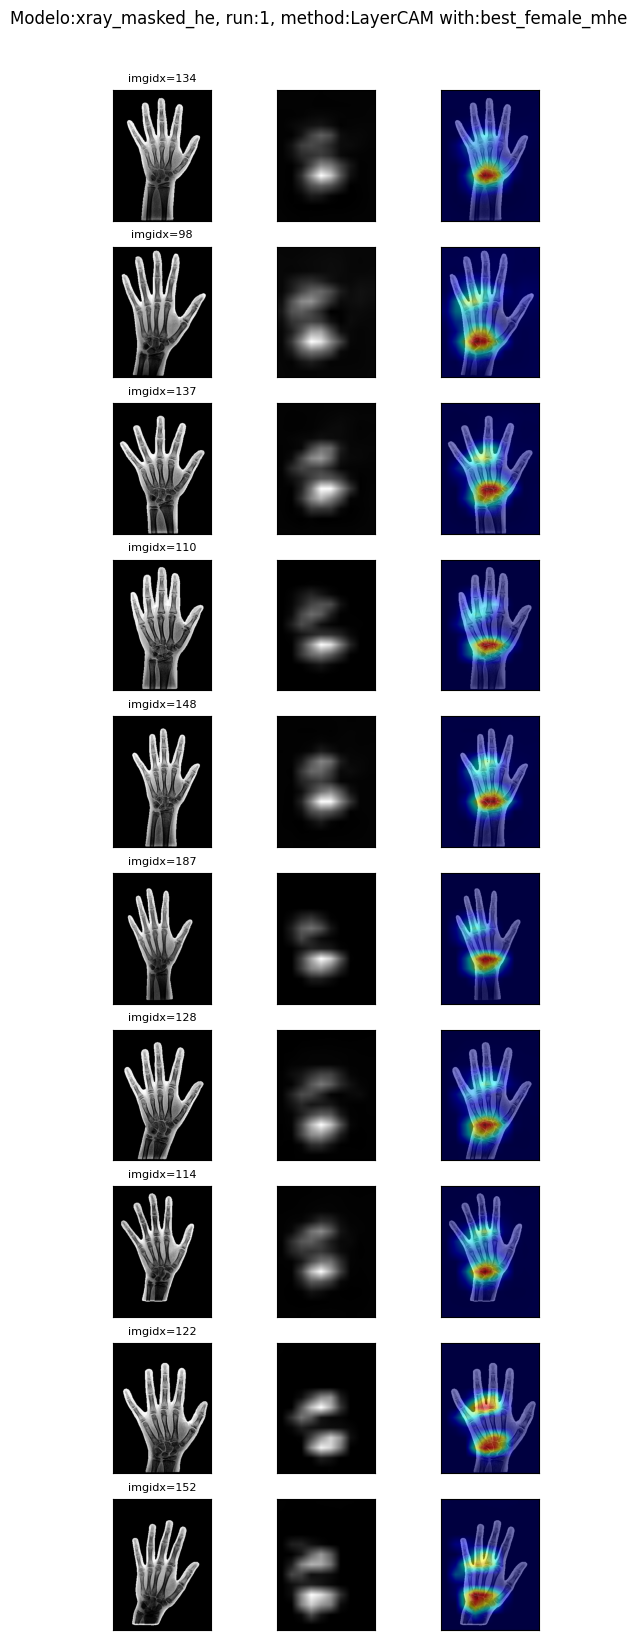

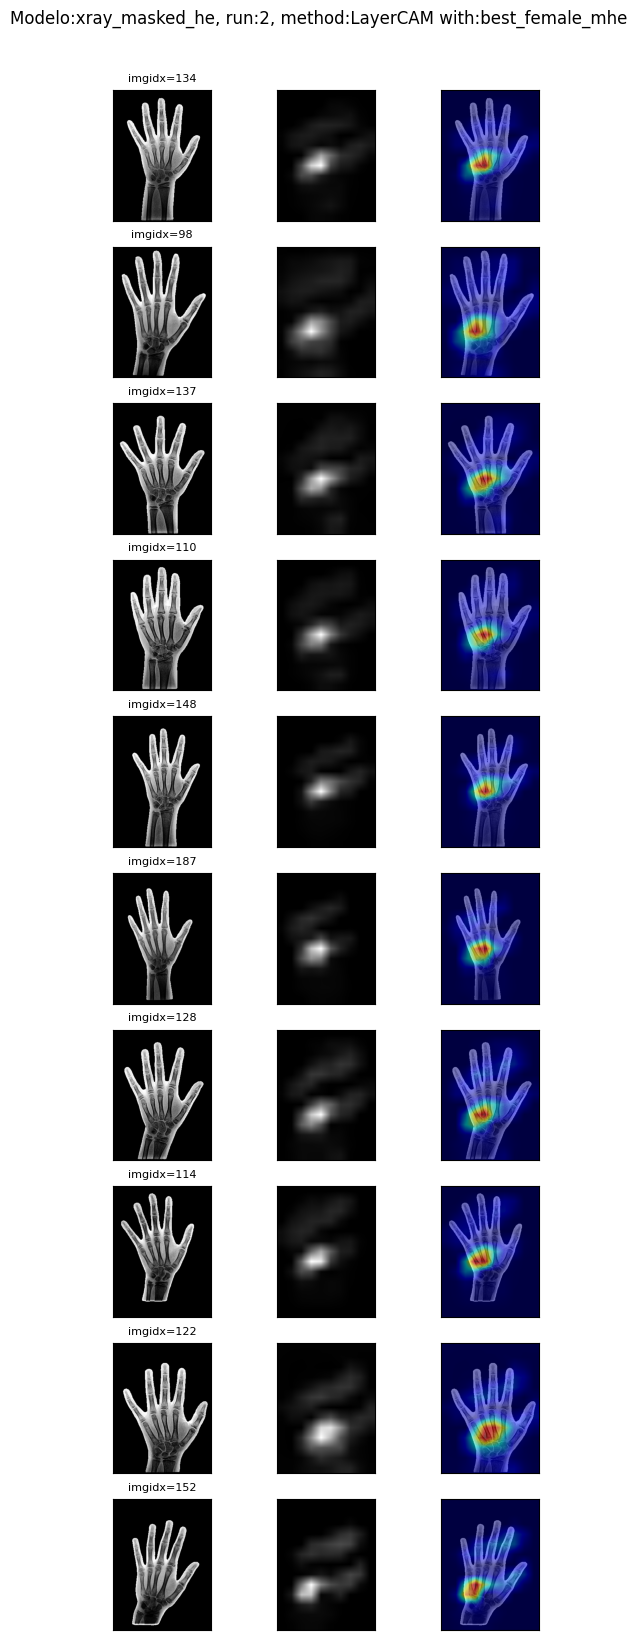

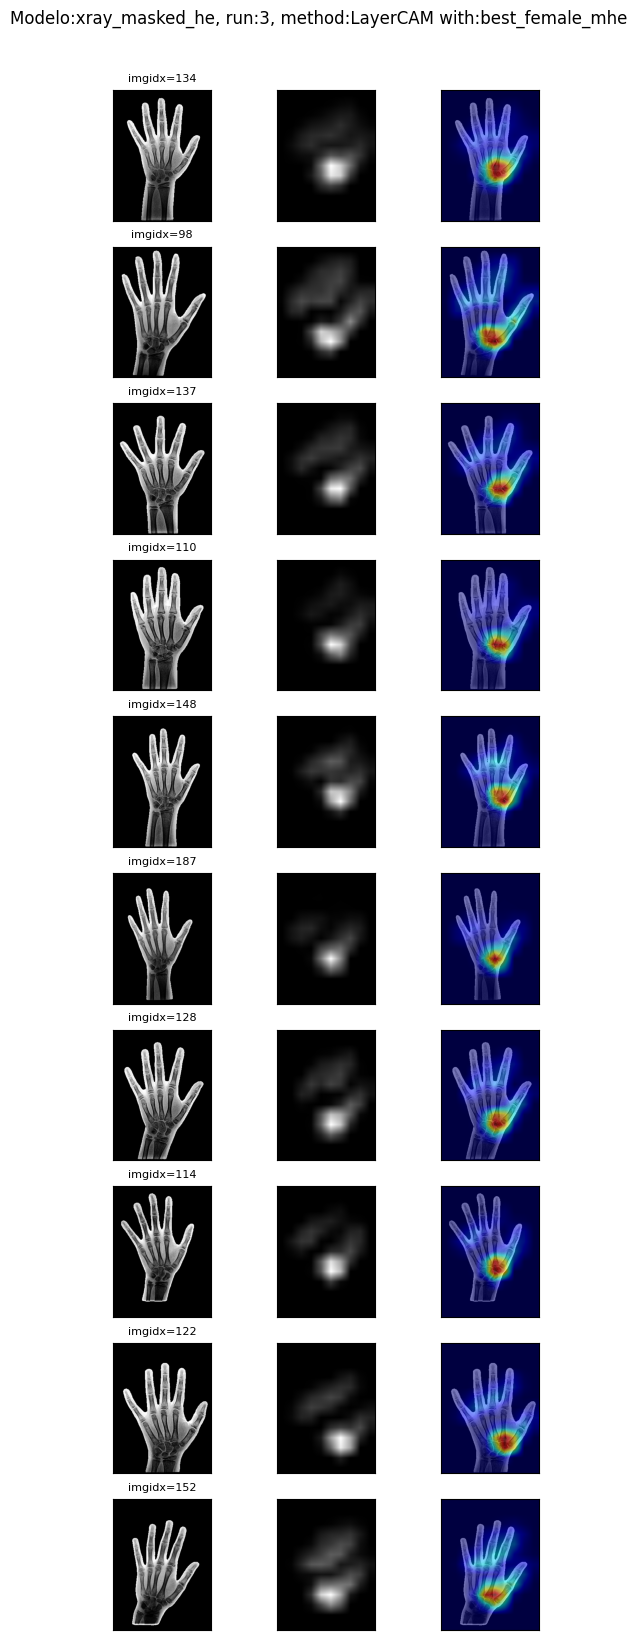

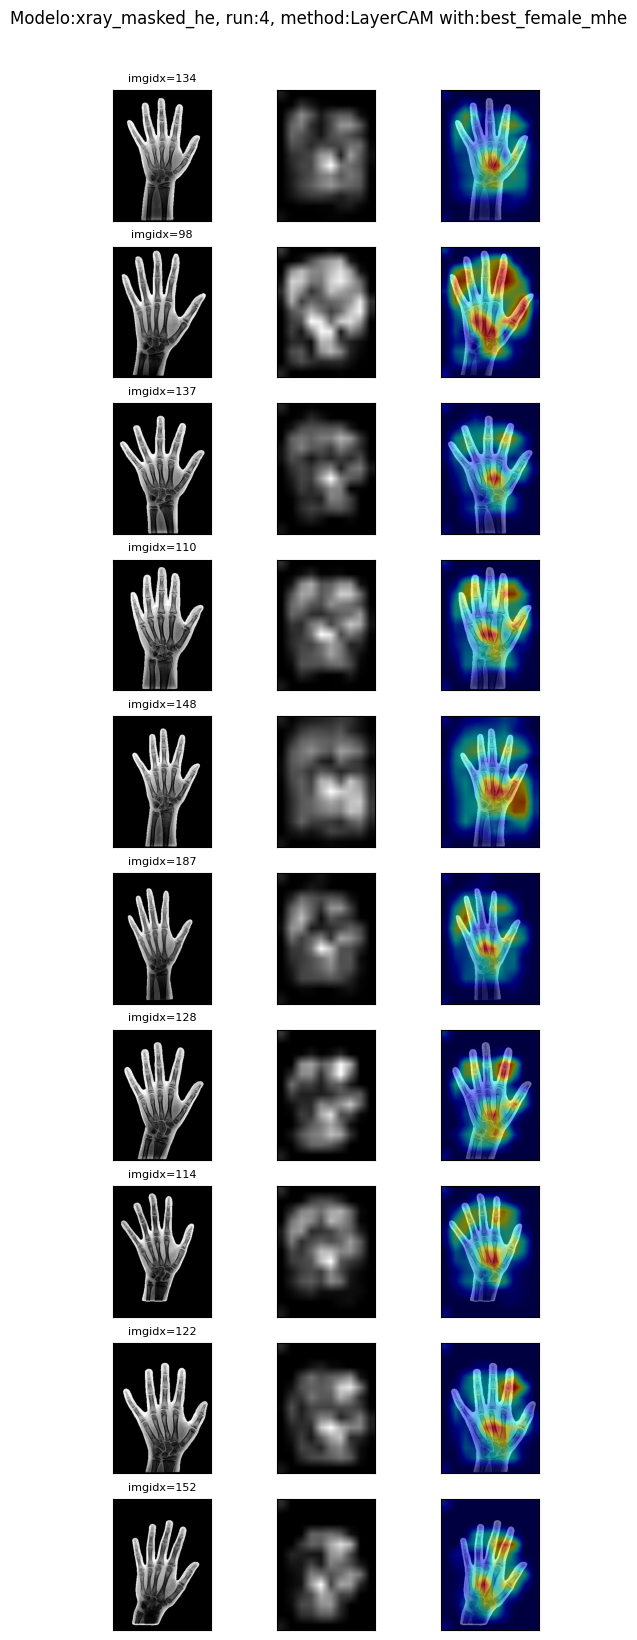

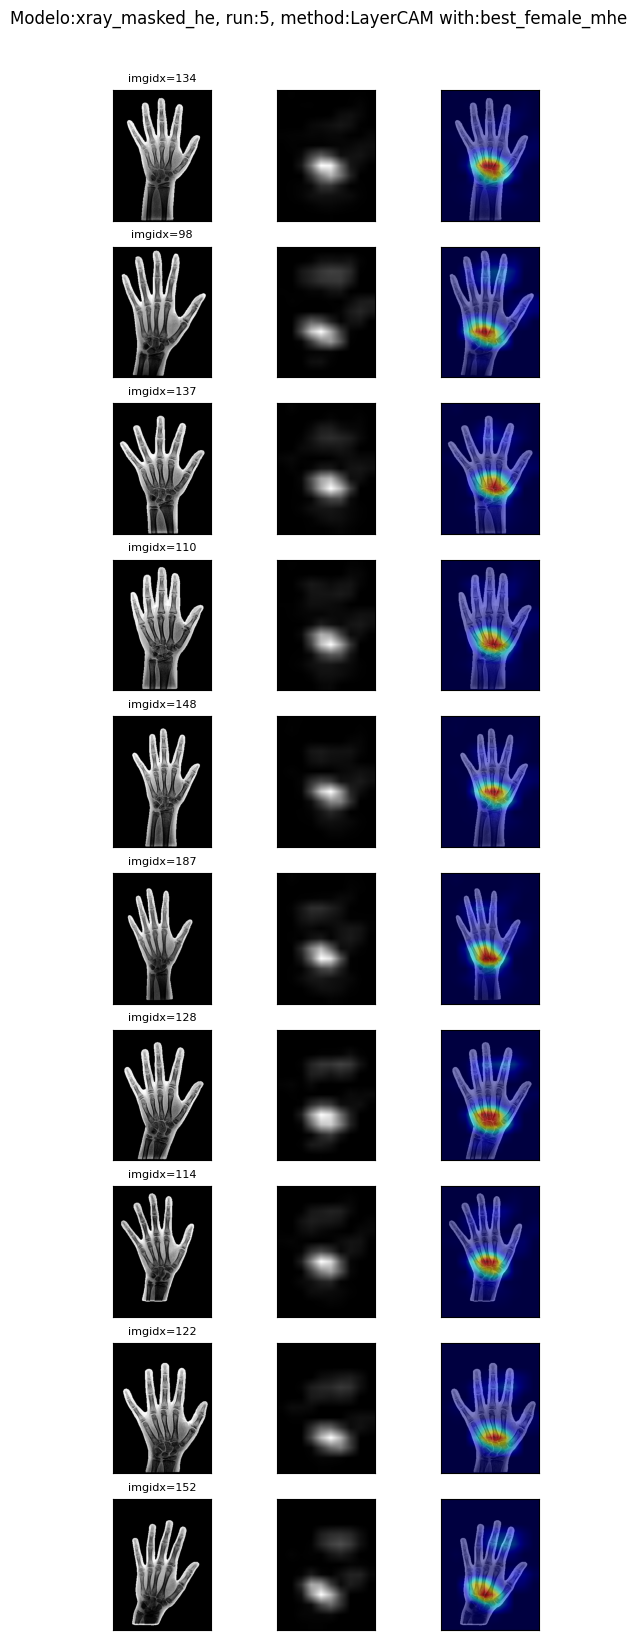

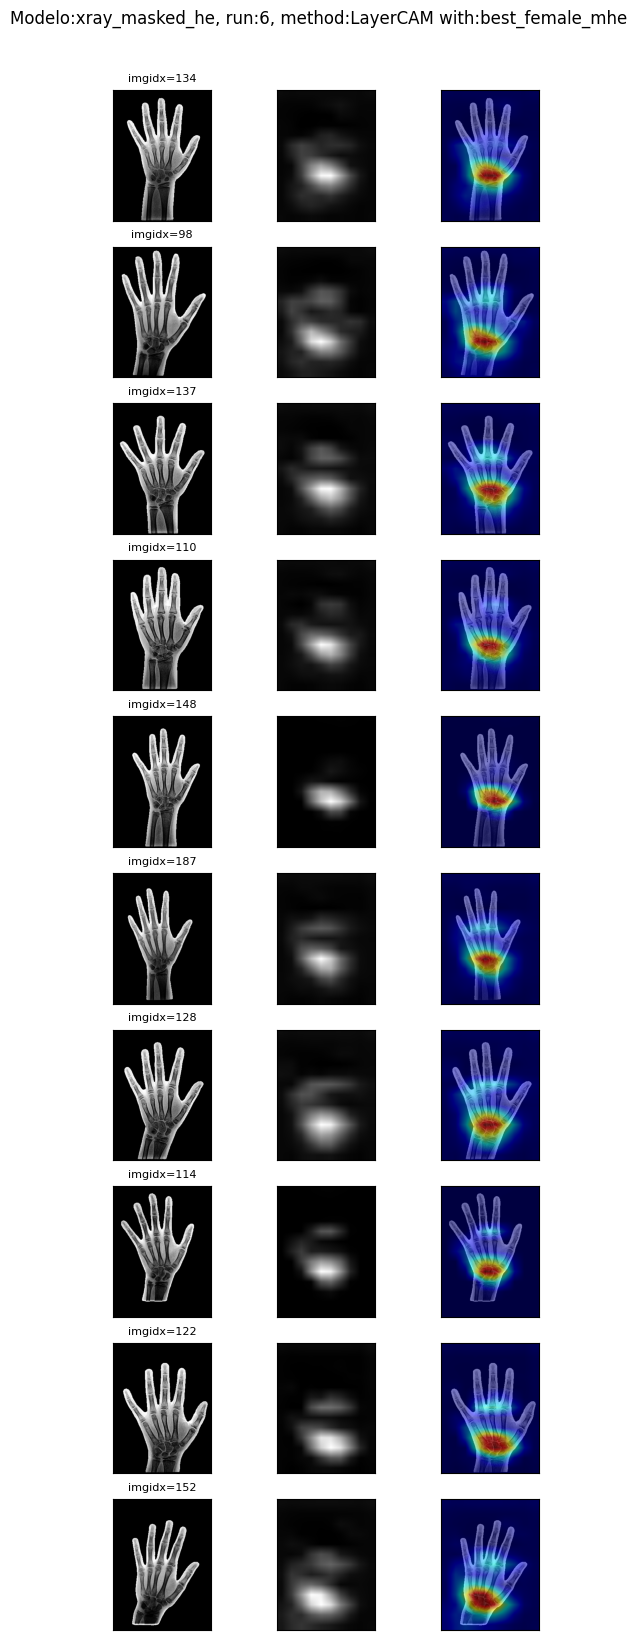

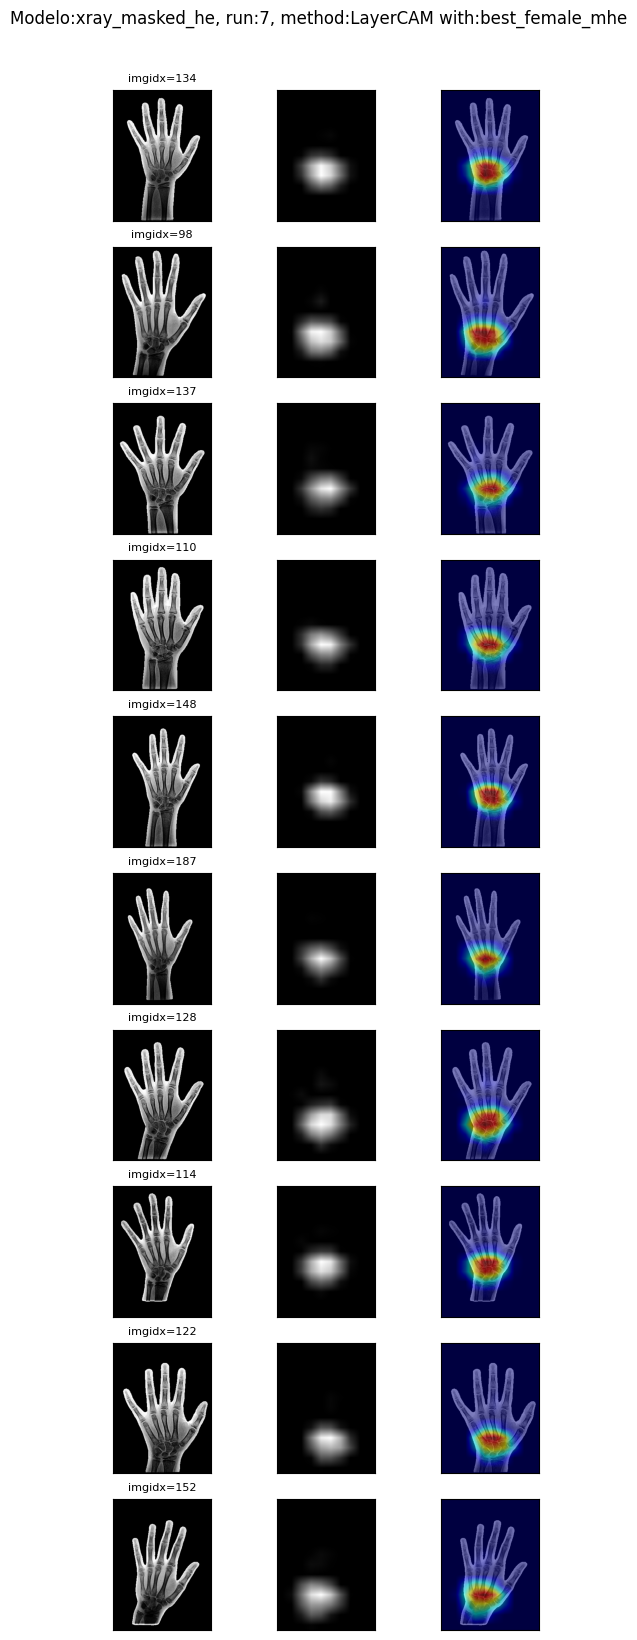

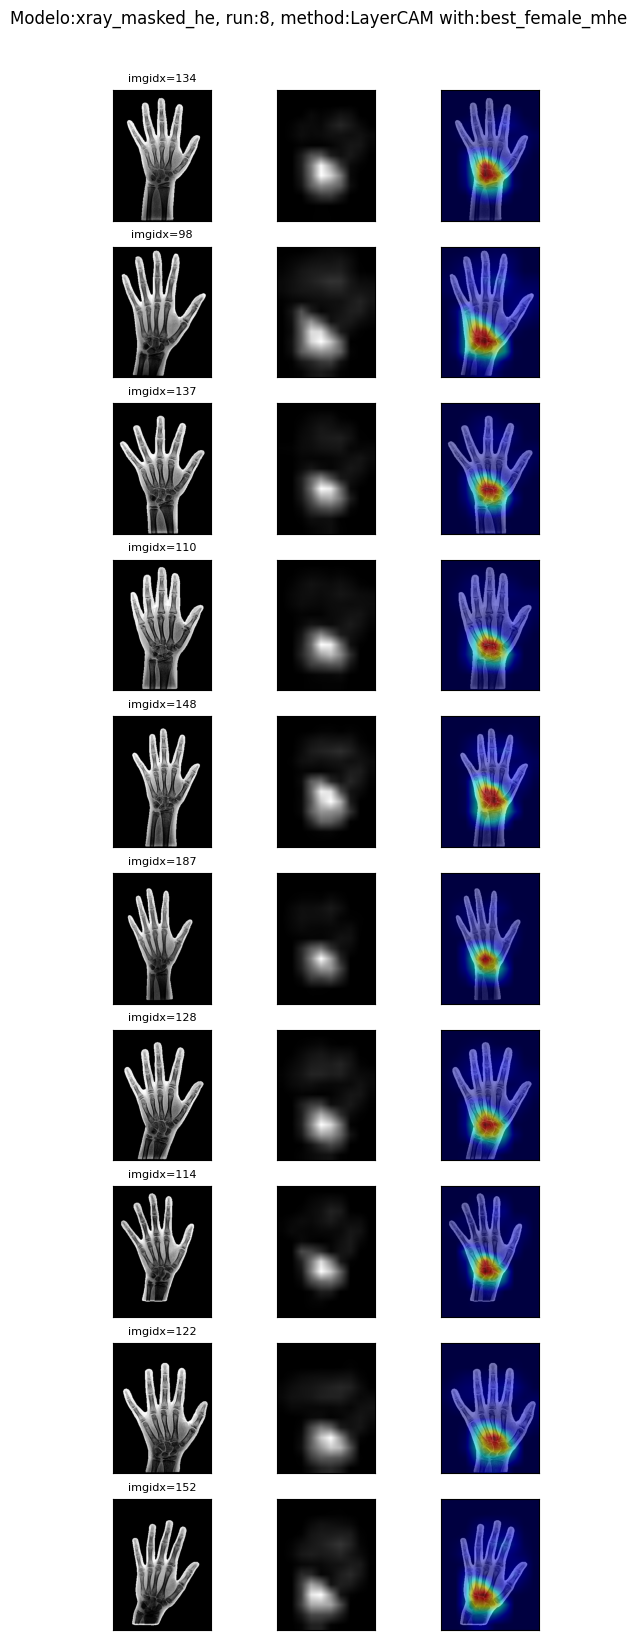

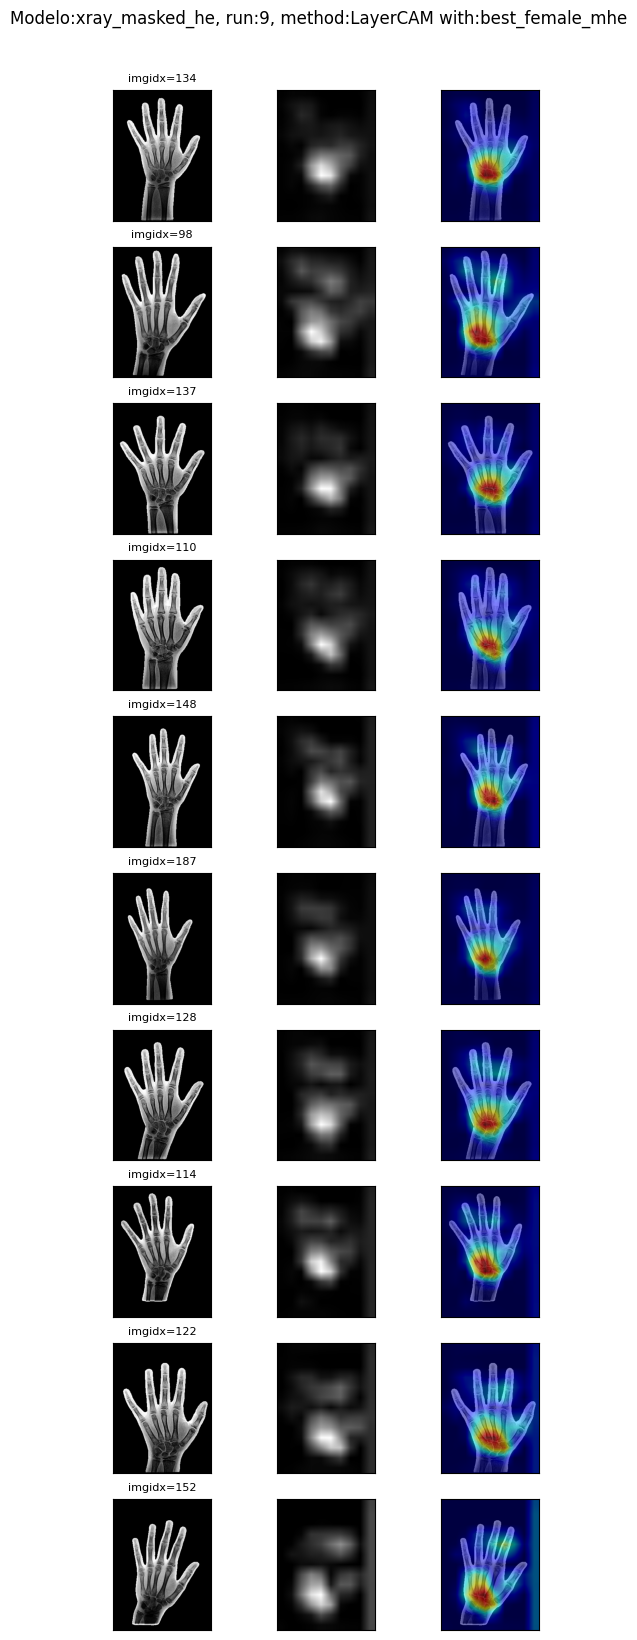

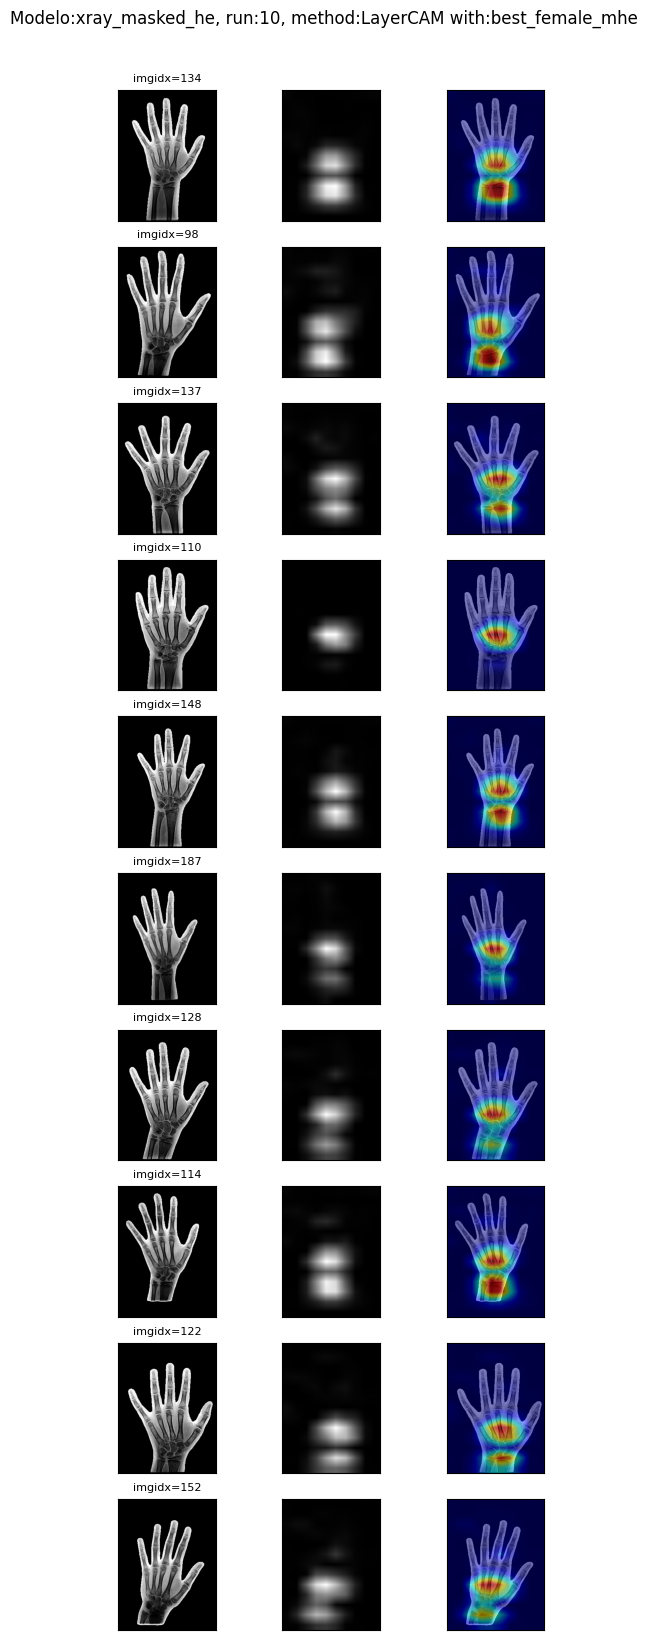

In [ ]:
#visualizing all cams
def vizualization(name, indexs, img, gray_cams):
    fig = plt.figure(figsize=(6, 20))
    axes = fig.subplots(len(indexs), 3)
    for j in range(len(indexs)):
        axes[j,0].imshow(np.uint8(255*img[j])[:,:,0], cmap='gray')
        axes[j,0].set_xticks([])
        axes[j,0].set_yticks([])
        axes[j,0].set_title(f'imgidx={str(indexs[j])}', fontsize=8)

        cam = np.uint8(255*gray_cams[j])
        cam = cv2.merge([cam, cam, cam])
        axes[j,1].imshow(cam)
        axes[j,1].set_xticks([])
        axes[j,1].set_yticks([])

        xray_image = np.array([img[j][:,:,0], img[j][:,:,0], img[j][:,:,0]]).transpose(1,2,0)
        cam_image = show_cam_on_image(xray_image, gray_cams[j], use_rgb=True)
        axes[j,2].imshow(cam_image)
        axes[j,2].set_xticks([])
        axes[j,2].set_yticks([])
        fig.suptitle(name, y=0.92)
    #fig.savefig('/content/drive/MyDrive/ai-sex-class-paper-main/attributions/results/' + f'{name}.png')
    plt.show()

k = 5 #method LayerCam  [GradCAM, GradCAMPlusPlus, XGradCAM,  EigenCAM, HiResCAM,  LayerCAM]
num_of_runs = len(runs_by_models[0])
model_name = ['xray_masked_he', 'xray_original', 'xray_masked']
cams_names = ['GradCAM', 'GradCAMPlusPlus', 'XGradCAM', 'EigenCAM', 'HiResCAM',  'LayerCAM']

for d in range(len(model_name)): #by models
    for i, idxs in enumerate(data_sets_idxs[d]): #by datasets indexes
        for j in range(num_of_runs): #by runs
            name = f'Modelo:{model_name[d]}, run:{str(j+1)}, method:{cams_names[k]} with:{data_sets_names[d][i]}'
            vizualization(name, idxs, imgs_by_models[d][i], cams_by_models[d][i,j,k,0])

In [ ]:
#Saving all the data
np.save(WORKING_FOLDER +'/results_allruns_cams_masked_he.npy', cams_by_models[0])
np.save(WORKING_FOLDER +'/results_allruns_imgs_masked_he.npy', imgs_by_models[0])
np.save(WORKING_FOLDER +'/results_allruns_cams_originals.npy', cams_by_models[1])
np.save(WORKING_FOLDER +'/results_allruns_imgs_originals.npy', imgs_by_models[1])
np.save(WORKING_FOLDER +'/results_allruns_cams_omasks.npy', cams_by_models[2])
np.save(WORKING_FOLDER +'/results_allruns_imgs_omasks.npy', imgs_by_models[2])

In [ ]:
#Cheking the sizes
print(cams_by_models[0].shape)
print(cams_by_models[1].shape)
print(cams_by_models[2].shape)
print(imgs_by_models[0].shape)
print(imgs_by_models[1].shape)
print(imgs_by_models[2].shape)